# Artigo 7
* Aluno: Paulo Henrique Costa Gontijo
* Matrícula: 15/0143800
* Lição: **
* Notebooks: 
  * **
  * **

| Hitórico de versão | Data |
|:--------------------:|:------:|
| v1 | 24/01/2023 |

## Propósito
Este artigo tem a intenção de documentar o passo a passo da quarta lição do curso, mostrando os blocos de códigos, o resultado das execuções, eventuais problemas encontrados e, se houver, as possíveis soluções para os problemas.

## Tema
A lição X do curso FastAi

> Caso tenha problemas para ver os gráficos, acesse este link para [nbviewer](https://nbviewer.org/github/paulohgontijoo/fastaiOnCampus/blob/main/artigos/lesson-7/150143800_paulohgontijoo_Paulo_Henrique_Costa_Gontijo.ipynb).

In [1]:
import fastbook
fastbook.setup_book()

## Importação das Bibliotecas

In [2]:
import os
import pandas as pd

file_name = 'test.jsonl'
file_path = '/'.join([os.getcwd(), file_name])

## Criando Cluster Spark

In [111]:
from pyspark.sql import SparkSession
from pyspark import SparkConf
from os.path import abspath

warehouse_location = abspath('spark-warehouse')

    # init session
spark = SparkSession \
        .builder \
        .appName("otto-reccomender-competition-kaggle") \
        .config("spark.sql.warehouse.dir", abspath('spark-warehouse')) \
        .config("spark.sql.execution.arrow.pyspark.enabled", "true")\
        .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "true")\
        .config("spark.driver.maxResultSize", "20g")\
        .enableHiveSupport() \
        .getOrCreate()

# show configured parameters
print(SparkConf().getAll())

# set log level
spark.sparkContext.setLogLevel("WARN")

23/01/31 20:13:42 WARN Utils: Your hostname, gobellek-B660M-DS3H-DDR4 resolves to a loopback address: 127.0.1.1; using 192.168.0.37 instead (on interface enp3s0)
23/01/31 20:13:42 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/31 20:13:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
[('spark.app.name', 'otto-reccomender-competition-kaggle'), ('spark.app.submitTime', '1675206823111'), ('spark.sql.execution.arrow.pyspark.fallback.enabled', 'true'), ('spark.sql.catalogImplementation', 'hive'), ('spark.driver.maxResultSize', '20g'), ('spark.master', 'local[*]'), ('spark.submit.pyFiles', ''), ('spark.submit.deployMode', 'client'), ('spark.sql.warehouse.dir', '/home/gobellek/Documents/UnB/mlops/fastaiOnCampus/artigos/lesson-7/spark-warehouse'), ('spark.ui.showConsoleProgress', 'true'), ('spark.sql.execution.arrow.pyspark.enabled', 'true')]


In [112]:
spark

In [113]:
import pyspark.pandas as ps
ps.set_option('compute.ops_on_diff_frames', True)

In [114]:
df_raw = spark.read \
    .format("json") \
    .option("inferSchema", "true") \
    .option("header", "true") \
    .json(file_path)
df_raw.columns

['events', 'session']

In [115]:
print(df_raw.rdd.getNumPartitions())

20


In [116]:
df_raw.show(10)

+--------------------+--------+
|              events| session|
+--------------------+--------+
|[{59625, 16617240...|12899779|
|[{1142000, 166172...|12899780|
|[{141736, 1661724...|12899781|
|[{1669402, 166172...|12899782|
|[{255297, 1661724...|12899783|
|[{1036375, 166172...|12899784|
|[{1784451, 166172...|12899785|
|[{955252, 1661724...|12899786|
|[{1682750, 166172...|12899787|
|[{245131, 1661724...|12899788|
+--------------------+--------+
only showing top 10 rows



In [117]:
df_raw.count()

1671803

In [118]:
df_raw.printSchema()

root
 |-- events: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- aid: long (nullable = true)
 |    |    |-- ts: long (nullable = true)
 |    |    |-- type: string (nullable = true)
 |-- session: long (nullable = true)



In [119]:
from pyspark.sql import functions as F
from pyspark.sql import types as T
df_explode = df_raw.withColumn('events_explode', F.explode('events'))\
                    .withColumn('session', F.col('session').cast(T.IntegerType()))\
                    .withColumn('aid', F.col('events_explode.aid').cast(T.IntegerType()))\
                    .withColumn('ts', F.col('events_explode.ts'))\
                    .withColumn('type', F.col('events_explode.type'))\
                    .drop('events', 'events_explode')
df_explode.show(10)

+--------+-------+-------------+------+
| session|    aid|           ts|  type|
+--------+-------+-------------+------+
|12899779|  59625|1661724000278|clicks|
|12899780|1142000|1661724000378|clicks|
|12899780| 582732|1661724058352|clicks|
|12899780| 973453|1661724109199|clicks|
|12899780| 736515|1661724136868|clicks|
|12899780|1142000|1661724155248|clicks|
|12899781| 141736|1661724000559|clicks|
|12899781| 199008|1661724022851|clicks|
|12899781|  57315|1661724170835|clicks|
|12899781| 194067|1661724246188|clicks|
+--------+-------+-------------+------+
only showing top 10 rows



In [120]:
df_explode.count()

6928123

In [121]:
df_explode.printSchema()

root
 |-- session: integer (nullable = true)
 |-- aid: integer (nullable = true)
 |-- ts: long (nullable = true)
 |-- type: string (nullable = true)



In [122]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol='type', outputCol='type_cat')
indexer_fitted = indexer.fit(df_explode)
df_indexed = indexer_fitted.transform(df_explode)
df_indexed = df_indexed.withColumn('type_cat', F.col('type_cat').cast(T.IntegerType())).drop('type')
df_indexed = df_indexed.drop('ts')
df_indexed.show(10)

+--------+-------+--------+
| session|    aid|type_cat|
+--------+-------+--------+
|12899779|  59625|       0|
|12899780|1142000|       0|
|12899780| 582732|       0|
|12899780| 973453|       0|
|12899780| 736515|       0|
|12899780|1142000|       0|
|12899781| 141736|       0|
|12899781| 199008|       0|
|12899781|  57315|       0|
|12899781| 194067|       0|
+--------+-------+--------+
only showing top 10 rows



In [123]:
df_indexed.printSchema()

root
 |-- session: integer (nullable = true)
 |-- aid: integer (nullable = true)
 |-- type_cat: integer (nullable = true)



In [124]:
df_indexed.describe().show()

+-------+--------------------+-----------------+-------------------+
|summary|             session|              aid|           type_cat|
+-------+--------------------+-----------------+-------------------+
|  count|             6928123|          6928123|            6928123|
|   mean|1.3709380360242017E7|926079.1729328419| 0.1011776205474412|
| stddev|   482705.8948930256|537170.4704612262|0.33142629982131566|
|    min|            12899779|                0|                  0|
|    max|            14571581|          1855600|                  2|
+-------+--------------------+-----------------+-------------------+



## Análise de Clientes

* Quantidade de clientes únicos

In [125]:
df_indexed.select('session').distinct().count()

1671803

* Clientes que mais interagiram

In [126]:
df_indexed.groupby(df_indexed.session).agg(F.count("*").alias('count')).orderBy(F.col("count").desc()).show()

+--------+-----+
| session|count|
+--------+-----+
|14086824|  458|
|13352358|  433|
|13242700|  421|
|13234219|  407|
|13346726|  406|
|13932091|  405|
|12937717|  403|
|14337964|  392|
|13944570|  389|
|13038203|  381|
|13952253|  380|
|13227072|  373|
|12921005|  369|
|13687115|  367|
|13457765|  366|
|13286072|  354|
|12983116|  350|
|13027861|  348|
|14380856|  346|
|13801272|  345|
+--------+-----+
only showing top 20 rows



* Clientes que mais compraram

In [127]:
df_indexed.filter("type_cat==2").groupBy('session').agg(F.count('type_cat').alias('count')).orderBy(F.col('count').desc()).show()

+--------+-----+
| session|count|
+--------+-----+
|13421767|   42|
|12907490|   38|
|13452871|   34|
|12925019|   33|
|13632426|   28|
|13739789|   28|
|12912725|   27|
|12920404|   27|
|12972816|   27|
|13095366|   26|
|13194346|   26|
|13479426|   26|
|13366124|   26|
|14322421|   26|
|12923288|   26|
|12949775|   26|
|13991681|   26|
|13136809|   25|
|13011704|   25|
|12970876|   24|
+--------+-----+
only showing top 20 rows



## Análise de Produtos

* Quantidade de produtos únicos

In [128]:
df_indexed.select('aid').distinct().count()

783486

* Produtos mais comprados

In [129]:
df_indexed.filter("type_cat==2").groupBy('aid').agg(F.count('*').alias('count')).orderBy(F.col('count').desc()).show()

+-------+-----+
|    aid|count|
+-------+-----+
| 986164|   74|
|1460571|   70|
| 329725|   54|
|1043508|   54|
| 332654|   47|
| 688602|   45|
|  29735|   44|
|1495817|   43|
| 579690|   39|
|1006198|   39|
|1022566|   39|
| 832192|   38|
| 471073|   38|
| 544144|   37|
| 836852|   34|
|1825743|   34|
| 147526|   32|
|1236775|   32|
| 166037|   32|
|1030009|   31|
+-------+-----+
only showing top 20 rows



* Produtos mais colocados em carrinho

In [130]:
df_indexed.filter("type_cat==1").groupBy('aid').agg(F.count('*').alias('count')).orderBy(F.col('count').desc()).show()

+-------+-----+
|    aid|count|
+-------+-----+
| 485256| 2001|
|  33343|  528|
|1460571|  482|
| 986164|  481|
| 554660|  447|
| 660655|  397|
|1116095|  396|
| 152547|  366|
|1022566|  361|
| 544144|  336|
| 832192|  329|
| 579690|  312|
| 329725|  309|
|1043508|  305|
| 558573|  290|
|1006198|  290|
| 471073|  288|
| 332654|  273|
| 688602|  272|
|  29735|  255|
+-------+-----+
only showing top 20 rows



* Produtos mais clicados

In [131]:
df_indexed.filter("type_cat==0").groupBy('aid').agg(F.count('*').alias('count')).orderBy(F.col('count').desc()).show()

+-------+-----+
|    aid|count|
+-------+-----+
|1460571| 8318|
| 485256| 7055|
| 108125| 6115|
| 986164| 4014|
|1551213| 3574|
| 754412| 3311|
| 554660| 3192|
| 832192| 3074|
| 579690| 2965|
|  33343| 2910|
|1006198| 2670|
| 688602| 2658|
|  29735| 2637|
| 329725| 2600|
| 184976| 2511|
|1019736| 2465|
| 496180| 2307|
| 861401| 2275|
| 944778| 2252|
| 659399| 2212|
+-------+-----+
only showing top 20 rows



In [132]:
# df_indexed.coalesce(1)\
#         .write.format('csv')\
#         .option("header", "True")\
#         .mode("overwrite")\
#         .save('/'.join([os.getcwd(), 'test.csv']))

spark.stop()

## Carregamento dos Dados 
Utilizando a classe **TabularPandas**, a fim de criar o bloco de dados insumo para treinamento do modelo. As variáveis definidas abaixo significam:

* `y_names`: Coluna alvo de regressão.
* `cat_names`: Coluna de variáveis categóricas, caso existissem no exemplo.
* `cont_names`: Coluna de variáveis contínuas, ou seja, estão em formato numérico.
* `splits`: representa uma função de segregação das vases de teste e validação, aplicando a proporção passada em *valid_pct*.


In [4]:
def list_csv_in_dir(path):
    dir_path = '/'.join([os.getcwd(), path])
    list_files = []
    for path in os.scandir(dir_path):
        if path.is_file():
            if path.name.endswith('.csv'):
                list_files.append(path.name)
    return list_files
list_files = list_csv_in_dir('data.csv') 
list_files

['part-00001-e6bfdd99-73da-4ebc-a420-d71150c63f00-c000.csv',
 'part-00000-e6bfdd99-73da-4ebc-a420-d71150c63f00-c000.csv']

## Colaborative Filtering


In [5]:
path = '/'.join([os.getcwd(),'data.csv',list_files[0]])
df = pd.read_csv(filepath_or_buffer=path, nrows=1000000)
df = df.fillna(df.mode().iloc[0])
df.head(20)

,session,aid,type_cat
0,3983334,1668263,0
1,3983334,198635,0
2,3983334,75856,0
3,3983334,559635,0
4,3983335,1019238,0
5,3983335,1672025,0
6,3983335,1500899,0
7,3983335,1628617,0
8,3983335,246358,0
9,3983335,1628617,0


* Reposicionando colunas

In [6]:
df = df[['session', 'aid', 'type_cat']]

* Dividindo o Dataset

In [7]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.3, shuffle=True, random_state=104)
del df

In [8]:
train_df.head()

,session,aid,type_cat
216865,3995188,22345,0
794843,4025767,658272,0
418389,4005410,876464,0
992552,4036501,1020945,0
215303,3995061,1403007,0


In [9]:
test_df.head()

,session,aid,type_cat
184717,3993473,633760,0
711204,4021304,1010674,0
215170,3995050,108575,0
79440,3987745,1436846,0
180842,3993279,39283,0


* Carga em CollabDLS

In [10]:
from fastai.collab import *
dls = CollabDataLoaders.from_df(train_df, item_name='aid', bs=1024)
dls.train.show_batch()

,session,aid,type_cat
0,4001383,1094896,0
1,3997864,994983,0
2,4033578,1777938,0
3,3989966,261434,0
4,4015659,1821991,0
5,4021957,1154908,0
6,3986600,442632,0
7,4002864,1259848,0
8,4020123,1281587,0
9,3995933,1180416,0


In [11]:
str(dls.classes)[:200]

"{'session': ['#na#', 3983334, 3983335, 3983336, 3983337, 3983338, 3983339, 3983341, 3983342, 3983343, 3983344, 3983345, 3983346, 3983347, 3983348, 3983349, 3983350, 3983351, 3983352, 3983353, 3983354,"

SuggestedLRs(valley=0.033113110810518265)
Learning Rate:  0.033113110810518265


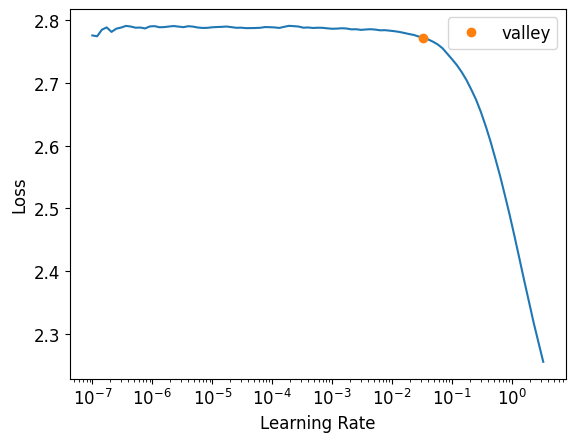

In [12]:
learn = collab_learner(dls, n_factors=2, y_range=(0, 3.5))
lr_rate = learn.lr_find()
print(lr_rate)
lr=(lr_rate[0])
print('Learning Rate: ',lr)

In [13]:
learn.fit_one_cycle(5, lr)

In [14]:
learn.show_results()

,session,aid,type_cat,type_cat_pred
0,29608,150100,0,0.086861
1,26279,29257,0,1.083799
2,5718,149528,0,0.107440
3,37296,188704,0,0.169148
4,36985,191558,0,0.074888
5,0,0,0,1.747226
6,23441,0,0,0.070368
7,46047,175885,0,0.037660
8,10151,0,0,0.387636


In [15]:
users_bias = learn.model.u_bias.weight.squeeze()
print('User_bias: ', str(users_bias)[:100], '\nLenght: ', len(users_bias))
print()

user_idxs = users_bias.argsort(descending=True)[:]
print('Users_biases_idxs: ', str(user_idxs)[:100], '\nLenght: ', len(user_idxs))
print()

users_values = [dls.classes['session'][i] for i in user_idxs]
print('Value in Users_biases_idxs: ', str(users_values)[:100], '\nLenght: ',len(users_values))
print()

item_bias = learn.model.i_bias.weight.squeeze()
print('Item_bias: ', str(item_bias)[:100],'\nLenght: ', len(item_bias))
print()

item_idxs = item_bias.argsort(descending=True)[:]
print('Item_biases_idxs: ', str(item_idxs)[:100],'\nLenght: ', len(item_idxs))
print()

item_values = [dls.classes['aid'][i] for i in item_idxs]
print('Value in Item_biases_idxs: ', str(item_values)[:100], '\nLenght: ', len(item_values))
print()

User_bias:  tensor([-0.0045, -1.4868, -2.6146,  ..., -1.5290, -0.5770, -2.5531], grad_fn=<SqueezeBackward0>) 
Lenght:  51130

Users_biases_idxs:  tensor([ 1591, 16621, 15711,  ..., 23721, 15645, 18107]) 
Lenght:  51130

Value in Users_biases_idxs:  [3985011, 4000767, 3999812, 3999416, 4007732, 3985114, 4012336, 4020562, 3997966, 4033978, 4003625,  
Lenght:  51130

Item_bias:  tensor([ 0.0013, -0.2647, -1.0522,  ..., -0.4244, -0.7188, -0.5330], grad_fn=<SqueezeBackward0>) 
Lenght:  202152

Item_biases_idxs:  tensor([166154,  42115,  36928,  ..., 148729,  86411,  10557]) 
Lenght:  202152

Value in Item_biases_idxs:  [1527113, 386532, 338402, 1313777, 963529, 280164, 1493684, 1797076, 353918, 295501, 1303458, 806569 
Lenght:  202152



In [16]:
learn.save("collab_model")

Path('models/collab_model.pth')

## Validação

In [17]:
list_files = list_csv_in_dir('test.csv')
list_files

['part-00000-984d7694-fcfb-4478-9d92-365147c91c54-c000.csv']

In [18]:
path = '/'.join([os.getcwd(),'test.csv',list_files[0]])
df_test = pd.read_csv(filepath_or_buffer=path)
df_test = df_test.fillna(df_test.mode().iloc[0])
df_test.head(20)

,session,aid,type_cat
0,12899779,59625,0
1,12899780,1142000,0
2,12899780,582732,0
3,12899780,973453,0
4,12899780,736515,0
5,12899780,1142000,0
6,12899781,141736,0
7,12899781,199008,0
8,12899781,57315,0
9,12899781,194067,0


In [19]:
dls_test = CollabDataLoaders.from_df(df_test , item_name='aid', bs=1024)

In [20]:
learn_load = learn.load('collab_model')

In [21]:
import numpy as np
class UserRatings:
    def __init__(self, user_id=None, all_items=None):
        self.user_id = user_id
        self.all_items = all_items

    def create_dict(self):
        array = np.arange(0, len((self.all_items)), 1)
        return dict(zip(self.all_items, array))

    def create_df(self, learner):
        new_df = pd.DataFrame()
        # include all items
        new_df["aid"] = self.all_items
        # define a user
        new_df["session"] = self.user_id
        # create the fastai test object
        dl = learner.dls.test_dl(new_df)
        # safe the predictions in a new column
        new_df["rating"] = learner.get_preds(dl=dl)[0]
        # reduce the dataframe to the 100 top rated movie predictions
        return new_df.nlargest(20, "rating")

def exec_write_submission_file(user_id, list_aid, learn, file):
    ur = UserRatings(user_id, list_aid)
    user_pred_df = ur.create_df(learn)
    aid_values = str(' '.join(list(user_pred_df.aid.astype(str).values)))

    file.write(f"{user_id}_clicks,{aid_values}\n")
    file.write(f"{user_id}_carts,{aid_values}\n")
    file.write(f"{user_id}_orders,{aid_values}\n")


import multiprocessing as mp
from joblib import Parallel, delayed
from tqdm import tqdm

list_aid = df_test.aid.unique()
num_cores = mp.cpu_count()
pool = mp.Pool(num_cores)
inputs = tqdm(df_test.session.unique())
file = open("submit.csv", "a")
for each in inputs:
    exec_write_submission_file(each, list_aid, learn, file)
file.close()

# Parallel(n_jobs=num_cores)(delayed(exec_write_submission_file)(user_id, list_aid, learn, file) for user_id in inputs)


  0%|          | 0/1671803 [00:00<?, ?it/s]

  0%|          | 1/1671803 [00:01<706:07:50,  1.52s/it]

  0%|          | 2/1671803 [00:02<678:08:19,  1.46s/it]

  0%|          | 3/1671803 [00:04<659:47:36,  1.42s/it]

  0%|          | 4/1671803 [00:05<659:33:09,  1.42s/it]

  0%|          | 5/1671803 [00:07<650:47:03,  1.40s/it]

  0%|          | 6/1671803 [00:08<655:35:15,  1.41s/it]

  0%|          | 7/1671803 [00:09<653:24:26,  1.41s/it]

  0%|          | 8/1671803 [00:11<652:00:12,  1.40s/it]

  0%|          | 9/1671803 [00:12<653:11:21,  1.41s/it]

  0%|          | 10/1671803 [00:14<662:14:45,  1.43s/it]

  0%|          | 11/1671803 [00:15<654:54:05,  1.41s/it]

  0%|          | 12/1671803 [00:16<653:04:06,  1.41s/it]

  0%|          | 13/1671803 [00:18<659:54:16,  1.42s/it]

  0%|          | 14/1671803 [00:19<651:39:35,  1.40s/it]

  0%|          | 15/1671803 [00:21<688:50:29,  1.48s/it]

  0%|          | 16/1671803 [00:22<671:31:45,  1.45s/it]

  0%|          | 17/1671803 [00:24<664:36:37,  1.43s/it]

  0%|          | 18/1671803 [00:25<658:11:16,  1.42s/it]

  0%|          | 19/1671803 [00:26<650:22:28,  1.40s/it]

  0%|          | 20/1671803 [00:28<650:35:03,  1.40s/it]

  0%|          | 21/1671803 [00:30<670:29:21,  1.44s/it]Process ForkPoolWorker-3:
Process ForkPoolWorker-1:
Process ForkPoolWorker-6:

Process ForkPoolWorker-8:
Process ForkPoolWorker-5:
Process ForkPoolWorker-7:
Process ForkPoolWorker-4:
Process ForkPoolWorker-14:
Process ForkPoolWorker-17:
Process ForkPoolWorker-11:
Process ForkPoolWorker-18:
Process ForkPoolWorker-13:
Process ForkPoolWorker-10:
Process ForkPoolWorker-2:
Process ForkPoolWorker-16:
Process ForkPoolWorker-15:
Process ForkPoolWorker-20:
Process ForkPoolWorker-12:
Process ForkPoolWorker-19:
Process ForkPoolWorker-9:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call

KeyboardInterrupt: 

  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()


In [132]:
learn.classes

KeyError: 0

In [177]:

def Convert(lst):
    array = np.arange(0,len(lst),1)
    return dict(zip(lst,array))

session_dict = Convert(uniques)
session_dict

TypeError: 'dict' object is not callable

In [162]:
import joblib
import math
from tqdm import tqdm

# create a new dataframe for the test object for the fastai model
lista = list()




def print_func(df, learn, dict)->lista:
    new_df = pd.DataFrame()
    # include all items
    new_df["aid"] = df["aid"].unique()
    # define a user
    new_df["session"] = df["session"].unique()[i]
    # create the fastai test object
    dl = learn.dls.test_dl(new_df)
    # safe the predictions in a new column
    new_df["rating"] = learn.get_preds(dl=dl)[0]
    # reduce the dataframe to the 100 top rated movie predictions
    new_df = new_df.nlargest(20, "rating")
    return new_df

from multiprocessing import Pool
pool = Pool(15)
result = pool.map(print_func(df, learn, lista), df["session"].unique())
pool.close()

# lista_proc = joblib.Parallel(n_jobs=10)(joblib.delayed(print_func(df, learn,lista))(i) for i in tqdm(range(len(df["session"].unique()))))



  0%|          | 0/1671803 [00:00<?, ?it/s]

100%|██████████| 1671803/1671803 [00:00<00:00, 11116510.10it/s]A


TypeError: 'list' object is not callable

In [161]:
from tqdm import tqdm
# create a new dataframe for the test object for the fastai model
df_append = pd.DataFrame()
lista = list()
for i in tqdm(range(len(df["session"].unique()))):
    # new_df = pd.DataFrame()
    #
    # # include all items
    # new_df["aid"] = df["aid"].unique()
    #
    # # define a user
    # new_df["session"] = df["session"].unique()[i]
    #
    # # create the fastai test object
    # dl = learn.dls.test_dl(new_df)
    #
    # # safe the predictions in a new column
    # new_df["rating"] = learn.get_preds(dl=dl)[0]
    #
    # # reduce the dataframe to the 100 top rated movie predictions
    # new_df = new_df.nlargest(20, "rating")
    #
    # lista.append(new_df)
    print_func(df, learn, lista, i)



  0%|          | 0/1671803 [00:00<?, ?it/s]



  0%|          | 1/1671803 [00:01<754:45:13,  1.63s/it]



  0%|          | 2/1671803 [00:03<741:43:34,  1.60s/it]



  0%|          | 3/1671803 [00:04<728:01:58,  1.57s/it]



  0%|          | 4/1671803 [00:06<728:47:29,  1.57s/it]



  0%|          | 5/1671803 [00:07<724:04:22,  1.56s/it]



  0%|          | 6/1671803 [00:09<725:39:41,  1.56s/it]



  0%|          | 7/1671803 [00:10<723:08:56,  1.56s/it]



  0%|          | 8/1671803 [00:12<708:52:25,  1.53s/it]



  0%|          | 9/1671803 [00:13<707:08:37,  1.52s/it]



  0%|          | 10/1671803 [00:15<697:55:20,  1.50s/it]



  0%|          | 11/1671803 [00:16<690:59:38,  1.49s/it]



  0%|          | 12/1671803 [00:18<693:49:50,  1.49s/it]



  0%|          | 13/1671803 [00:19<691:09:17,  1.49s/it]



  0%|          | 14/1671803 [00:21<691:38:51,  1.49s/it]



  0%|          | 15/1671803 [00:22<693:32:19,  1.49s/it]



  0%|          | 16/1671803 [00:24<693:03:04,  1.49s/it]



  0%|          | 17/1671803 [00:25<699:20:13,  1.51s/it]



  0%|          | 18/1671803 [00:27<710:12:46,  1.53s/it]



  0%|          | 19/1671803 [00:29<716:26:21,  1.54s/it]



  0%|          | 20/1671803 [00:30<711:34:24,  1.53s/it]



  0%|          | 21/1671803 [00:32<709:32:39,  1.53s/it]



  0%|          | 22/1671803 [00:33<705:33:36,  1.52s/it]



  0%|          | 23/1671803 [00:35<706:45:11,  1.52s/it]



  0%|          | 24/1671803 [00:36<707:09:22,  1.52s/it]



  0%|          | 25/1671803 [00:38<705:35:57,  1.52s/it]



  0%|          | 26/1671803 [00:39<706:22:00,  1.52s/it]



  0%|          | 27/1671803 [00:41<707:14:36,  1.52s/it]



  0%|          | 28/1671803 [00:42<704:00:40,  1.52s/it]



  0%|          | 29/1671803 [00:44<708:14:59,  1.53s/it]



  0%|          | 30/1671803 [00:45<704:32:36,  1.52s/it]



  0%|          | 31/1671803 [00:47<706:11:23,  1.52s/it]



  0%|          | 32/1671803 [00:48<708:26:02,  1.53s/it]



  0%|          | 33/1671803 [00:50<703:39:14,  1.52s/it]



  0%|          | 34/1671803 [00:51<707:53:35,  1.52s/it]



  0%|          | 35/1671803 [00:53<717:00:26,  1.54s/it]



  0%|          | 36/1671803 [00:54<711:42:32,  1.53s/it]



  0%|          | 37/1671803 [00:56<706:12:16,  1.52s/it]



  0%|          | 38/1671803 [00:57<705:15:25,  1.52s/it]



  0%|          | 39/1671803 [00:59<702:25:33,  1.51s/it]



  0%|          | 40/1671803 [01:00<701:55:12,  1.51s/it]



  0%|          | 41/1671803 [01:02<697:23:55,  1.50s/it]



  0%|          | 42/1671803 [01:04<712:17:20,  1.53s/it]



  0%|          | 43/1671803 [01:05<712:35:12,  1.53s/it]



  0%|          | 44/1671803 [01:07<708:28:08,  1.53s/it]



  0%|          | 45/1671803 [01:08<705:40:57,  1.52s/it]



  0%|          | 46/1671803 [01:10<698:38:58,  1.50s/it]



  0%|          | 47/1671803 [01:11<697:26:23,  1.50s/it]



  0%|          | 48/1671803 [01:12<690:17:08,  1.49s/it]



  0%|          | 49/1671803 [01:14<693:39:39,  1.49s/it]



  0%|          | 50/1671803 [01:15<694:45:26,  1.50s/it]



  0%|          | 51/1671803 [01:17<693:01:23,  1.49s/it]



  0%|          | 52/1671803 [01:18<697:48:18,  1.50s/it]



  0%|          | 53/1671803 [01:20<695:02:30,  1.50s/it]



  0%|          | 54/1671803 [01:22<706:33:29,  1.52s/it]



  0%|          | 55/1671803 [01:23<707:19:43,  1.52s/it]



  0%|          | 56/1671803 [01:25<702:30:42,  1.51s/it]



  0%|          | 57/1671803 [01:26<705:57:21,  1.52s/it]



  0%|          | 58/1671803 [01:28<712:00:58,  1.53s/it]



  0%|          | 59/1671803 [01:29<717:19:07,  1.54s/it]



  0%|          | 60/1671803 [01:31<716:46:28,  1.54s/it]



  0%|          | 61/1671803 [01:32<721:10:28,  1.55s/it]



  0%|          | 62/1671803 [01:34<725:21:45,  1.56s/it]



  0%|          | 63/1671803 [01:35<716:33:27,  1.54s/it]



  0%|          | 64/1671803 [01:37<719:47:18,  1.55s/it]



  0%|          | 65/1671803 [01:39<717:49:43,  1.55s/it]



  0%|          | 66/1671803 [01:40<715:42:22,  1.54s/it]



  0%|          | 67/1671803 [01:42<714:04:56,  1.54s/it]



  0%|          | 68/1671803 [01:43<711:48:13,  1.53s/it]



  0%|          | 69/1671803 [01:45<713:20:35,  1.54s/it]



  0%|          | 70/1671803 [01:46<711:48:27,  1.53s/it]



  0%|          | 71/1671803 [01:48<706:56:51,  1.52s/it]



  0%|          | 72/1671803 [01:49<702:41:46,  1.51s/it]



  0%|          | 73/1671803 [01:51<704:43:23,  1.52s/it]



  0%|          | 74/1671803 [01:52<700:16:25,  1.51s/it]



  0%|          | 75/1671803 [01:54<696:34:20,  1.50s/it]

  0%|          | 75/1671803 [01:55<713:01:33,  1.54s/it]


KeyboardInterrupt: 

,aid,session,rating
133404,1115178,12899779,3.047564
2801,353918,12899779,2.978744
195596,1852599,12899779,2.933954
218157,1590801,12899779,2.899814
248048,85904,12899779,2.899201
335198,1753474,12899779,2.897740
371619,1777710,12899779,2.891610
21921,1725813,12899779,2.885669
135723,1485583,12899779,2.872840
153519,1114913,12899779,2.872817


In [136]:
new_df.sort_values(by='rating', ascending=False).iloc[:20]

,aid,session,rating
54840,1115178,10549,3.047564
99682,1852599,10549,2.933954
119468,1753474,10549,2.897740
107878,1777710,10549,2.891610
55832,1725813,10549,2.885669
916,1114913,10549,2.872817
75911,278779,10549,2.871994
82876,917964,10549,2.859293
5064,1562707,10549,2.853120
96769,318701,10549,2.844163


In [99]:
# include the current user
new_df["session"] = row["tbl_rating_user_id"]

# create the fastai test object
dl = learn.dls.test_dl(new_df)

# safe the predictions in a new column
new_df["rating"] = learn.get_preds(dl=dl)[0]

# reduce the dataframe to the 100 top rated movie predictions
new_df = new_df.nlargest(100, "rating")

TypeError: list indices must be integers or slices, not list

In [100]:
test_df.to_list()

AttributeError: 'DataFrame' object has no attribute 'to_list'

In [27]:
top_products = df[df['type_cat'] == 2].drop('type_cat', axis=1).groupby('aid').count().sort_values(by='session',ascending=False).drop('session', axis=1).iloc[:30]
top_products = list(top_products.index)
top_products

NameError: name 'df' is not defined

In [208]:
product_bias = learn.model.bias(top_products, is_item=True)
print(product_bias.shape)
product_bias

torch.Size([2])


tensor([-0.1853, -0.2465])

In [259]:
mean_ratings = df.groupby('aid')['type_cat'].mean()
product_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_products,product_bias)]
product_ratings

[(tensor(-0.1853), 1047057, 0.6), (tensor(-0.2465), 1255243, 0.625)]

In [260]:
sorted(product_ratings, key=lambda o: o[0], reverse=True)[:20]

[(tensor(-0.1853), 1047057, 0.6), (tensor(-0.2465), 1255243, 0.625)]

In [196]:
top_users = df[df['type_cat'] == 2].drop('type_cat', axis=1).groupby('session').count().sort_values(by='aid', ascending=False).drop('aid',axis=1).iloc[:100]
top_users = list(top_users.index)
top_users

[137]

In [209]:
user_bias = learn.model.bias(top_users, is_item=False)
user_bias

tensor(-0.2548)

In [274]:
mean_ratings = df.groupby('session')['type_cat'].mean()
user_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_users,user_bias)]
user_ratings

TypeError: iteration over a 0-d tensor

In [194]:
df.groupby('session')['type_cat'].mean()

session
31     0.000000
85     0.043478
137    0.267606
Name: type_cat, dtype: float64

## Predição

## Deploy do modelo
O modelo foi implantado no ambiente **HuggingFace**, conforme em outras lições e pode ser acessado por este link: https://huggingface.co/spaces/paulohgontijoo/tabular-fastai-lesson-5

# Referências Bibliográficas

> https://github.com/Kaggle/kaggle-api

> https://www.youtube.com/watch?v=aBNQzWV_UmE

> https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/968100988546031/157591980591166/8836542754149149/latest.html

> https://blog.clairvoyantsoft.com/apache-spark-out-of-memory-issue-b63c7987fff

> https://spark.apache.org/docs/latest/api/python/getting_started/quickstart_ps.html